# KNN регрессия


--- Базовый бейзлайн (KNN Regressor) ---

Baseline MSE:  0.1442
Baseline MAE:  0.3022
Baseline R^2:  0.0014

--- Улучшенный бейзлайн (с n-граммами + подбором гиперпараметров) ---



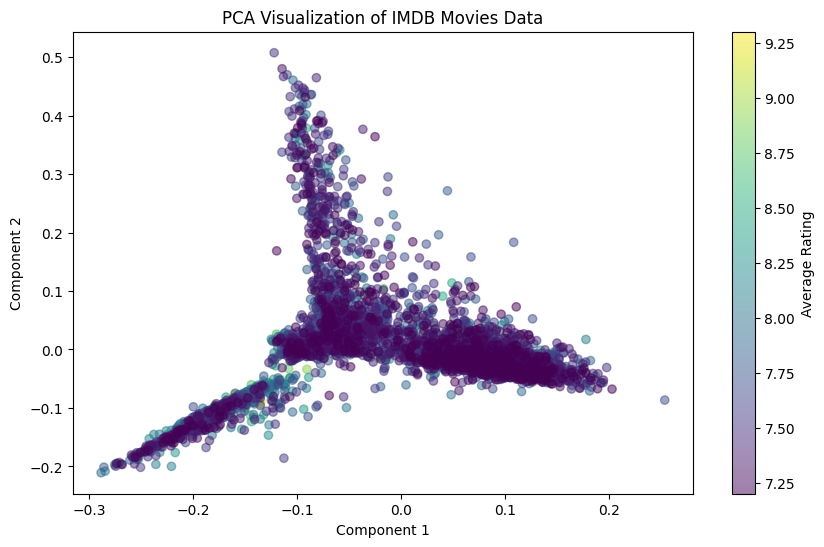

Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}

MSE (улучшенная модель):  0.1318
MAE (улучшенная модель):  0.2925
R^2 (улучшенная модель):  0.0869

--- Сравнение моделей ---
Baseline MSE:  0.1442   vs   Improved MSE:  0.1318
Baseline MAE:  0.3022   vs   Improved MAE:  0.2925
Baseline R^2:  0.0014    vs   Improved R^2:  0.0869


In [11]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

data_path = '/content/IMDB_Movies_Dataset.csv'
data = pd.read_csv(data_path)
def combine_text_columns(row):
    text_cols = ["Title", "Director", "Writer", "Cast", "Country of Origin", "Languages"]
    # Превращаем всё в строки и объединяем через пробел
    combined_text = " ".join([str(row[col]) for col in text_cols if pd.notnull(row[col])])
    return combined_text

data['combined_text'] = data.apply(combine_text_columns, axis=1)

#Предобработка текста
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    return text

data['processed_text'] = data['combined_text'].apply(preprocess_text)

# Формируем признаки (X) и целевую переменную (y)
X = data['processed_text']
y = data['Average Rating']  # Целевая переменная

# Удалим строки, у которых нет значения рейтинга (если такие есть)
combined_df = pd.concat([X, y], axis=1).dropna(subset=['Average Rating'])
X = combined_df['processed_text']
y = combined_df['Average Rating']

# Базовый бейзлайн
print("\n--- Базовый бейзлайн (KNN Regressor) ---\n")

# Преобразуем тексты в вектора TF-IDF
tfidf_vectorizer_base = TfidfVectorizer(max_features=5000)
X_tfidf_base = tfidf_vectorizer_base.fit_transform(X)

# Разделим данные на обучающую и тестовую выборки
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_tfidf_base, y, test_size=0.2, random_state=42
)

# Простая модель KNN Regressor
knn_reg_base = KNeighborsRegressor(n_neighbors=5)
knn_reg_base.fit(X_train_base, y_train_base)

# Предсказания
y_pred_base = knn_reg_base.predict(X_test_base)

# Оценка качества базовой регрессионной модели
mse_base = mean_squared_error(y_test_base, y_pred_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)
r2_base = r2_score(y_test_base, y_pred_base)

print(f"Baseline MSE:  {mse_base:.4f}")
print(f"Baseline MAE:  {mae_base:.4f}")
print(f"Baseline R^2:  {r2_base:.4f}")

#Улучшенный бейзлайн
print("\n--- Улучшенный бейзлайн (с n-граммами + подбором гиперпараметров) ---\n")

# Преобразуем тексты в вектора TF-IDF (c n-граммами)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Снижение размерности для визуализации (PCA)
X_tfidf_array = X_tfidf.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf_array)

plt.figure(figsize=(10, 6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of IMDB Movies Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
cbar = plt.colorbar(sc)
cbar.set_label('Average Rating')
plt.show()

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Подбор гиперпараметров (GridSearchCV) для KNeighborsRegressor
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'weights': ['uniform', 'distance']
}
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # для регрессии MSE
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

# Лучшая модель
best_knn_reg = grid_search.best_estimator_

# Обучаем и оцениваем качество
best_knn_reg.fit(X_train, y_train)
y_pred = best_knn_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE (улучшенная модель):  {mse:.4f}")
print(f"MAE (улучшенная модель):  {mae:.4f}")
print(f"R^2 (улучшенная модель):  {r2:.4f}")

# Сравнение результатов
print("\n--- Сравнение моделей ---")
print(f"Baseline MSE:  {mse_base:.4f}   vs   Improved MSE:  {mse:.4f}")
print(f"Baseline MAE:  {mae_base:.4f}   vs   Improved MAE:  {mae:.4f}")
print(f"Baseline R^2:  {r2_base:.4f}    vs   Improved R^2:  {r2:.4f}")


# Логистическая и линейная

In [15]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/IMDB_Movies_Dataset.csv'
data = pd.read_csv(data_path)

def combine_text_columns(row):
    text_cols = ["Title", "Director", "Writer", "Cast", "Country of Origin", "Languages"]
    combined_text = " ".join([str(row[col]) for col in text_cols if pd.notnull(row[col])])
    return combined_text

data["combined_text"] = data.apply(combine_text_columns, axis=1)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    return text

data["processed_text"] = data["combined_text"].apply(preprocess_text)

print("Число пропусков в Average Rating:", data["Average Rating"].isna().sum())

# Удаляем строки без рейтинга
data = data.dropna(subset=["Average Rating"])

# Просто на всякий случай (если есть строки, где всё пустое)
data = data.dropna(subset=["processed_text"])

print("Размер датасета после очистки:", data.shape)


##############################
# 1) ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ #
##############################

# Создадим бинарную метку: 1 (рейтинг >=8.3), 0 (рейтинг <8.3)
data["target_class"] = data["Average Rating"].apply(lambda x: 1 if x >= 8.3 else 0)

# Признаки (X) и метка (y)
X_class = data["processed_text"]
y_class = data["target_class"]

# Базовый вариант (TF-IDF)
print("\n--- Логистическая регрессия: БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base = TfidfVectorizer(max_features=5000)
X_tfidf_base_class = tfidf_vectorizer_base.fit_transform(X_class)

print("Распределение классов:")
print(data["target_class"].value_counts())

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_tfidf_base_class,
    y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class  # чтобы доли классов в train/test были одинаковыми
)

# Обучаем логистическую регрессию
logreg_base = LogisticRegression()
logreg_base.fit(X_train_b, y_train_b)

# Предсказание
y_pred_b = logreg_base.predict(X_test_b)

# Оценка
acc_base = accuracy_score(y_test_b, y_pred_b)
print(f"Accuracy (базовый): {acc_base:.4f}")
print("Classification Report (базовый):\n", classification_report(y_test_b, y_pred_b))
print("Confusion Matrix (базовый):\n", confusion_matrix(y_test_b, y_pred_b))


# Улучшенный вариант (TF-IDF с n-граммами + GridSearchCV)
print("\n--- Логистическая регрессия: УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_class = tfidf_vectorizer_adv.fit_transform(X_class)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_tfidf_adv_class, y_class, test_size=0.2, random_state=42
)

param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_logistic = GridSearchCV(
    LogisticRegression(max_iter=10000),
    param_grid_logistic,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_logistic.fit(X_train_a, y_train_a)

best_logreg = grid_logistic.best_estimator_
print("Лучшие параметры:", grid_logistic.best_params_)

# Оценка на тесте
y_pred_a = best_logreg.predict(X_test_a)
acc_adv = accuracy_score(y_test_a, y_pred_a)
print(f"Accuracy (улучшенный): {acc_adv:.4f}")
print("Classification Report (улучшенный):\n", classification_report(y_test_a, y_pred_a))
print("Confusion Matrix (улучшенный):\n", confusion_matrix(y_test_a, y_pred_a))

# Сравнение
print("\n--- Сравнение LogisticRegression ---")
print(f"Baseline Accuracy:   {acc_base:.4f}")
print(f"Improved Accuracy:   {acc_adv:.4f}")


##########################
# 2) ЛИНЕЙНАЯ РЕГРЕССИЯ   #
##########################

# Признаки (X) и целевая переменная (y)
X_reg = data["processed_text"]
y_reg = data["Average Rating"]  # продолжает оставаться числовой

### Базовый вариант (TF-IDF)
print("\n--- Линейная регрессия: БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base_reg = TfidfVectorizer(max_features=5000)
X_tfidf_base_reg = tfidf_vectorizer_base_reg.fit_transform(X_reg)

X_train_breg, X_test_breg, y_train_breg, y_test_breg = train_test_split(
    X_tfidf_base_reg, y_reg, test_size=0.2, random_state=42
)

# Обучаем линейную регрессию
linreg_base = LinearRegression()
linreg_base.fit(X_train_breg, y_train_breg)

# Предсказания
y_pred_breg = linreg_base.predict(X_test_breg)

# Оценка
mse_base = mean_squared_error(y_test_breg, y_pred_breg)
mae_base = mean_absolute_error(y_test_breg, y_pred_breg)
r2_base = r2_score(y_test_breg, y_pred_breg)

print(f"Baseline MSE: {mse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline R^2: {r2_base:.4f}")


# Улучшенный вариант (TF-IDF с n-граммами + GridSearchCV)
print("\n--- Линейная регрессия: УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv_reg = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_reg = tfidf_vectorizer_adv_reg.fit_transform(X_reg)

X_train_areg, X_test_areg, y_train_areg, y_test_areg = train_test_split(
    X_tfidf_adv_reg, y_reg, test_size=0.2, random_state=42
)

param_grid_linear = {
    'fit_intercept': [True, False],
}

grid_linear = GridSearchCV(
    LinearRegression(),
    param_grid_linear,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_linear.fit(X_train_areg, y_train_areg)

best_linreg = grid_linear.best_estimator_
print("Лучшие параметры (LinearRegression):", grid_linear.best_params_)

# Предсказания
y_pred_areg = best_linreg.predict(X_test_areg)

# Метрики
mse_adv = mean_squared_error(y_test_areg, y_pred_areg)
mae_adv = mean_absolute_error(y_test_areg, y_pred_areg)
r2_adv = r2_score(y_test_areg, y_pred_areg)

print(f"Improved MSE: {mse_adv:.4f}")
print(f"Improved MAE: {mae_adv:.4f}")
print(f"Improved R^2: {r2_adv:.4f}")

# Сравнение
print("\n--- Сравнение LinearRegression ---")
print(f"Baseline MSE: {mse_base:.4f}   vs   Improved MSE: {mse_adv:.4f}")
print(f"Baseline MAE: {mae_base:.4f}   vs   Improved MAE: {mae_adv:.4f}")
print(f"Baseline R^2: {r2_base:.4f}    vs   Improved R^2: {r2_adv:.4f}")


Число пропусков в Average Rating: 0
Размер датасета после очистки: (4989, 15)

--- Логистическая регрессия: БАЗОВЫЙ вариант ---

Распределение классов:
target_class
0    4662
1     327
Name: count, dtype: int64
Accuracy (базовый): 0.9369
Classification Report (базовый):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       933
           1       1.00      0.03      0.06        65

    accuracy                           0.94       998
   macro avg       0.97      0.52      0.51       998
weighted avg       0.94      0.94      0.91       998

Confusion Matrix (базовый):
 [[933   0]
 [ 63   2]]

--- Логистическая регрессия: УЛУЧШЕННЫЙ вариант ---

Лучшие параметры: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy (улучшенный): 0.9218
Classification Report (улучшенный):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       920
           1       0.00      0.00      0.00        7

текстовые признаки, видимо, не дают полезного сигнала для точного прогноза рейтинга. В датасет нужно добавить больше данных для более точного прогноза, только вот каких...

# Решающее дерево

In [18]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

data_path = "/content/IMDB_Movies_Dataset.csv"
data = pd.read_csv(data_path)


def combine_text_columns(row):
    text_cols = ["Title", "Director", "Writer", "Cast", "Country of Origin", "Languages"]
    combined_text = " ".join([str(row[col]) for col in text_cols if pd.notnull(row[col])])
    return combined_text

data["combined_text"] = data.apply(combine_text_columns, axis=1)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    return text

data["processed_text"] = data["combined_text"].apply(preprocess_text)

# Удаляем строки без рейтинга (Average Rating), если есть пропуски
data = data.dropna(subset=["Average Rating"])
data = data.dropna(subset=["processed_text"])

print("Размер датасета после очистки:", data.shape)

############################
# 1) ДЕРЕВО РЕШЕНИЙ (CLASSIFICATION)
############################

# Создаём бинарную метку
data["target_class"] = data["Average Rating"].apply(lambda x: 1 if x >= 8.3 else 0)

# Признаки (X) и метка (y)
X_class = data["processed_text"]
y_class = data["target_class"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)

print("\n--- Decision Tree (CLASSIFICATION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base = TfidfVectorizer(max_features=5000)
X_tfidf_base_class = tfidf_vectorizer_base.fit_transform(X_class)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_tfidf_base_class,
    y_class,
    test_size=0.2,
    random_state=42
)

# Простое дерево
dt_clf_base = DecisionTreeClassifier(random_state=42)
dt_clf_base.fit(X_train_b, y_train_b)

y_pred_b = dt_clf_base.predict(X_test_b)

acc_base = accuracy_score(y_test_b, y_pred_b)
print(f"Accuracy (базовый): {acc_base:.4f}")
print("Classification Report (базовый):\n", classification_report(y_test_b, y_pred_b))
print("Confusion Matrix (базовый):\n", confusion_matrix(y_test_b, y_pred_b))

# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF с n-граммами + GridSearch)

print("\n--- Decision Tree (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_class = tfidf_vectorizer_adv.fit_transform(X_class)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_tfidf_adv_class,
    y_class,
    test_size=0.2,
    random_state=42
)

# Подбор гиперпараметров дерева: max_depth, min_samples_split, min_samples_leaf
param_grid_class = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_dt_class = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_class,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_dt_class.fit(X_train_a, y_train_a)

best_dt_clf = grid_dt_class.best_estimator_
print("Лучшие параметры:", grid_dt_class.best_params_)

# Оценка
y_pred_a = best_dt_clf.predict(X_test_a)
acc_adv = accuracy_score(y_test_a, y_pred_a)
print(f"Accuracy (улучшенный): {acc_adv:.4f}")
print("Classification Report (улучшенный):\n", classification_report(y_test_a, y_pred_a))
print("Confusion Matrix (улучшенный):\n", confusion_matrix(y_test_a, y_pred_a))

# Сравнение
print("\n--- Сравнение DecisionTreeClassifier ---")
print(f"Baseline Accuracy:   {acc_base:.4f}")
print(f"Improved Accuracy:   {acc_adv:.4f}")


#######################
# 2) ДЕРЕВО РЕШЕНИЙ (REGRESSION)
#######################

X_reg = data["processed_text"]
y_reg = data["Average Rating"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)

print("\n--- Decision Tree (REGRESSION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base_reg = TfidfVectorizer(max_features=5000)
X_tfidf_base_reg = tfidf_vectorizer_base_reg.fit_transform(X_reg)

X_train_breg, X_test_breg, y_train_breg, y_test_breg = train_test_split(
    X_tfidf_base_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

dt_reg_base = DecisionTreeRegressor(random_state=42)
dt_reg_base.fit(X_train_breg, y_train_breg)

y_pred_breg = dt_reg_base.predict(X_test_breg)

mse_base = mean_squared_error(y_test_breg, y_pred_breg)
mae_base = mean_absolute_error(y_test_breg, y_pred_breg)
r2_base = r2_score(y_test_breg, y_pred_breg)

print(f"Baseline MSE: {mse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline R^2: {r2_base:.4f}")

# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF с n-граммами + GridSearch)

print("\n--- Decision Tree (REGRESSION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv_reg = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_reg = tfidf_vectorizer_adv_reg.fit_transform(X_reg)

X_train_areg, X_test_areg, y_train_areg, y_test_areg = train_test_split(
    X_tfidf_adv_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

param_grid_reg = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_dt_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_dt_reg.fit(X_train_areg, y_train_areg)

best_dt_reg = grid_dt_reg.best_estimator_
print("Лучшие параметры (DecisionTreeRegressor):", grid_dt_reg.best_params_)

y_pred_areg = best_dt_reg.predict(X_test_areg)
mse_adv = mean_squared_error(y_test_areg, y_pred_areg)
mae_adv = mean_absolute_error(y_test_areg, y_pred_areg)
r2_adv = r2_score(y_test_areg, y_pred_areg)

print(f"Improved MSE: {mse_adv:.4f}")
print(f"Improved MAE: {mae_adv:.4f}")
print(f"Improved R^2: {r2_adv:.4f}")

# Сравнение
print("\n--- Сравнение DecisionTreeRegressor ---")
print(f"Baseline MSE: {mse_base:.4f}   vs   Improved MSE: {mse_adv:.4f}")
print(f"Baseline MAE: {mae_base:.4f}   vs   Improved MAE: {mae_adv:.4f}")
print(f"Baseline R^2: {r2_base:.4f}    vs   Improved R^2: {r2_adv:.4f}")



Размер датасета после очистки: (4989, 15)

--- Decision Tree (CLASSIFICATION): БАЗОВЫЙ вариант ---

Accuracy (базовый): 0.8788
Classification Report (базовый):
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       920
           1       0.21      0.19      0.20        78

    accuracy                           0.88       998
   macro avg       0.57      0.56      0.57       998
weighted avg       0.88      0.88      0.88       998

Confusion Matrix (базовый):
 [[862  58]
 [ 63  15]]

--- Decision Tree (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy (улучшенный): 0.9208
Classification Report (улучшенный):
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       920
           1       0.48      0.14      0.22        78

    accuracy                           0.92       998
   macro avg       0.70      0.5

# Случайный лес

In [19]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

data_path = "/content/IMDB_Movies_Dataset.csv"
data = pd.read_csv(data_path)

def combine_text_columns(row):
    """
    Объединяем несколько текстовых столбцов в один
    (например, Title, Director, Writer, Cast, Country of Origin, Languages)
    """
    text_cols = ["Title", "Director", "Writer", "Cast", "Country of Origin", "Languages"]
    combined_text = " ".join([str(row[col]) for col in text_cols if pd.notnull(row[col])])
    return combined_text

data["combined_text"] = data.apply(combine_text_columns, axis=1)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    return text

data["processed_text"] = data["combined_text"].apply(preprocess_text)

# Удаляем строки без рейтинга
data = data.dropna(subset=["Average Rating"])
data = data.dropna(subset=["processed_text"])

print("Размер датасета после очистки:", data.shape)

############################################################################
# 2. КЛАССИФИКАЦИЯ (RandomForestClassifier)
############################################################################

data["target_class"] = data["Average Rating"].apply(lambda x: 1 if x >= 8.3 else 0)

X_class = data["processed_text"]
y_class = data["target_class"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)
print("\n--- RandomForest (CLASSIFICATION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
X_tfidf_base_class = tfidf_vectorizer_base.fit_transform(X_class)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_tfidf_base_class, y_class, test_size=0.2, random_state=42
)

rf_clf_base = RandomForestClassifier(random_state=42)
rf_clf_base.fit(X_train_b, y_train_b)

y_pred_b = rf_clf_base.predict(X_test_b)

acc_base = accuracy_score(y_test_b, y_pred_b)
print(f"Accuracy (базовый): {acc_base:.4f}")
print("Classification Report (базовый):\n", classification_report(y_test_b, y_pred_b))
print("Confusion Matrix (базовый):\n", confusion_matrix(y_test_b, y_pred_b))

# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF c n-граммами + GridSearchCV)
print("\n--- RandomForest (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_class = tfidf_vectorizer_adv.fit_transform(X_class)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_tfidf_adv_class, y_class, test_size=0.2, random_state=42
)

param_grid_class = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf_class = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_class,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_rf_class.fit(X_train_a, y_train_a)

best_rf_clf = grid_rf_class.best_estimator_
print("Лучшие параметры:", grid_rf_class.best_params_)

y_pred_a = best_rf_clf.predict(X_test_a)
acc_adv = accuracy_score(y_test_a, y_pred_a)
print(f"Accuracy (улучшенный): {acc_adv:.4f}")
print("Classification Report (улучшенный):\n", classification_report(y_test_a, y_pred_a))
print("Confusion Matrix (улучшенный):\n", confusion_matrix(y_test_a, y_pred_a))

# Сравнение
print("\n--- Сравнение RandomForestClassifier ---")
print(f"Baseline Accuracy:   {acc_base:.4f}")
print(f"Improved Accuracy:   {acc_adv:.4f}")

############################################################################
# 3. РЕГРЕССИЯ (RandomForestRegressor)
############################################################################

X_reg = data["processed_text"]
y_reg = data["Average Rating"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)
print("\n--- RandomForest (REGRESSION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base_reg = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
X_tfidf_base_reg = tfidf_vectorizer_base_reg.fit_transform(X_reg)

X_train_breg, X_test_breg, y_train_breg, y_test_breg = train_test_split(
    X_tfidf_base_reg, y_reg, test_size=0.2, random_state=42
)

rf_reg_base = RandomForestRegressor(random_state=42)
rf_reg_base.fit(X_train_breg, y_train_breg)

y_pred_breg = rf_reg_base.predict(X_test_breg)

mse_base = mean_squared_error(y_test_breg, y_pred_breg)
mae_base = mean_absolute_error(y_test_breg, y_pred_breg)
r2_base = r2_score(y_test_breg, y_pred_breg)

print(f"Baseline MSE: {mse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline R^2: {r2_base:.4f}")

# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF с n-граммами + GridSearchCV)
print("\n--- RandomForest (REGRESSION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv_reg = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_reg = tfidf_vectorizer_adv_reg.fit_transform(X_reg)

X_train_areg, X_test_areg, y_train_areg, y_test_areg = train_test_split(
    X_tfidf_adv_reg, y_reg, test_size=0.2, random_state=42
)

param_grid_reg = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf_reg = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_rf_reg.fit(X_train_areg, y_train_areg)

best_rf_reg = grid_rf_reg.best_estimator_
print("Лучшие параметры (RandomForestRegressor):", grid_rf_reg.best_params_)

y_pred_areg = best_rf_reg.predict(X_test_areg)

mse_adv = mean_squared_error(y_test_areg, y_pred_areg)
mae_adv = mean_absolute_error(y_test_areg, y_pred_areg)
r2_adv = r2_score(y_test_areg, y_pred_areg)

print(f"Improved MSE: {mse_adv:.4f}")
print(f"Improved MAE: {mae_adv:.4f}")
print(f"Improved R^2: {r2_adv:.4f}")

# Сравнение
print("\n--- Сравнение RandomForestRegressor ---")
print(f"Baseline MSE: {mse_base:.4f}   vs   Improved MSE: {mse_adv:.4f}")
print(f"Baseline MAE: {mae_base:.4f}   vs   Improved MAE: {mae_adv:.4f}")
print(f"Baseline R^2: {r2_base:.4f}    vs   Improved R^2: {r2_adv:.4f}")


Размер датасета после очистки: (4989, 15)

--- RandomForest (CLASSIFICATION): БАЗОВЫЙ вариант ---

Accuracy (базовый): 0.9279
Classification Report (базовый):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       920
           1       1.00      0.08      0.14        78

    accuracy                           0.93       998
   macro avg       0.96      0.54      0.55       998
weighted avg       0.93      0.93      0.90       998

Confusion Matrix (базовый):
 [[920   0]
 [ 72   6]]

--- RandomForest (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---

Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy (улучшенный): 0.9238
Classification Report (улучшенный):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       920
           1       1.00      0.03      0.05        78

    accuracy                           0.92       998
   macro avg

# Градиентный бустинг ✈

In [20]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

data_path = "/content/IMDB_Movies_Dataset.csv"
data = pd.read_csv(data_path)

def combine_text_columns(row):
    text_cols = ["Title", "Director", "Writer", "Cast", "Country of Origin", "Languages"]
    combined_text = " ".join([str(row[col]) for col in text_cols if pd.notnull(row[col])])
    return combined_text

data["combined_text"] = data.apply(combine_text_columns, axis=1)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    return text

data["processed_text"] = data["combined_text"].apply(preprocess_text)

# Убираем строки без рейтинга
data = data.dropna(subset=["Average Rating"])
data = data.dropna(subset=["processed_text"])

print("Размер датасета после очистки:", data.shape)

########################
# КЛАССИФИКАЦИЯ
########################

data["target_class"] = data["Average Rating"].apply(lambda x: 1 if x >= 8.3 else 0)

X_class = data["processed_text"]
y_class = data["target_class"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)
print("\n--- Gradient Boosting (CLASSIFICATION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base = TfidfVectorizer(max_features=5000)
X_tfidf_base_class = tfidf_vectorizer_base.fit_transform(X_class)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_tfidf_base_class,
    y_class,
    test_size=0.2,
    random_state=42
)

gb_clf_base = GradientBoostingClassifier(random_state=42)
gb_clf_base.fit(X_train_b, y_train_b)

y_pred_b = gb_clf_base.predict(X_test_b)

acc_base = accuracy_score(y_test_b, y_pred_b)
print(f"Accuracy (базовый): {acc_base:.4f}")
print("Classification Report (базовый):\n", classification_report(y_test_b, y_pred_b))
print("Confusion Matrix (базовый):\n", confusion_matrix(y_test_b, y_pred_b))


# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF с n-граммами + GridSearchCV)
print("\n--- Gradient Boosting (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_class = tfidf_vectorizer_adv.fit_transform(X_class)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_tfidf_adv_class,
    y_class,
    test_size=0.2,
    random_state=42
)

# Подбираем параметры: число деревьев (n_estimators), глубина (max_depth), learning_rate
param_grid_class = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1]
}

grid_gb_class = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_class,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_gb_class.fit(X_train_a, y_train_a)

best_gb_clf = grid_gb_class.best_estimator_
print("Лучшие параметры (Classification):", grid_gb_class.best_params_)

y_pred_a = best_gb_clf.predict(X_test_a)
acc_adv = accuracy_score(y_test_a, y_pred_a)
print(f"Accuracy (улучшенный): {acc_adv:.4f}")
print("Classification Report (улучшенный):\n", classification_report(y_test_a, y_pred_a))
print("Confusion Matrix (улучшенный):\n", confusion_matrix(y_test_a, y_pred_a))

# Сравнение
print("\n--- Сравнение GradientBoostingClassifier ---")
print(f"Baseline Accuracy:   {acc_base:.4f}")
print(f"Improved Accuracy:   {acc_adv:.4f}")

########################
# РЕГРЕССИЯ
########################

X_reg = data["processed_text"]
y_reg = data["Average Rating"]

# БАЗОВЫЙ ВАРИАНТ (TF-IDF)
print("\n--- Gradient Boosting (REGRESSION): БАЗОВЫЙ вариант ---\n")

tfidf_vectorizer_base_reg = TfidfVectorizer(max_features=5000)
X_tfidf_base_reg = tfidf_vectorizer_base_reg.fit_transform(X_reg)

X_train_breg, X_test_breg, y_train_breg, y_test_breg = train_test_split(
    X_tfidf_base_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

gb_reg_base = GradientBoostingRegressor(random_state=42)
gb_reg_base.fit(X_train_breg, y_train_breg)

y_pred_breg = gb_reg_base.predict(X_test_breg)

mse_base = mean_squared_error(y_test_breg, y_pred_breg)
mae_base = mean_absolute_error(y_test_breg, y_pred_breg)
r2_base = r2_score(y_test_breg, y_pred_breg)

print(f"Baseline MSE: {mse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline R^2: {r2_base:.4f}")


# УЛУЧШЕННЫЙ ВАРИАНТ (TF-IDF с n-граммами + GridSearchCV)
print("\n--- Gradient Boosting (REGRESSION): УЛУЧШЕННЫЙ вариант ---\n")

tfidf_vectorizer_adv_reg = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf_adv_reg = tfidf_vectorizer_adv_reg.fit_transform(X_reg)

X_train_areg, X_test_areg, y_train_areg, y_test_areg = train_test_split(
    X_tfidf_adv_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

param_grid_reg = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1]
}

grid_gb_reg = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_gb_reg.fit(X_train_areg, y_train_areg)

best_gb_reg = grid_gb_reg.best_estimator_
print("Лучшие параметры (Regression):", grid_gb_reg.best_params_)

y_pred_areg = best_gb_reg.predict(X_test_areg)

mse_adv = mean_squared_error(y_test_areg, y_pred_areg)
mae_adv = mean_absolute_error(y_test_areg, y_pred_areg)
r2_adv = r2_score(y_test_areg, y_pred_areg)

print(f"Improved MSE: {mse_adv:.4f}")
print(f"Improved MAE: {mae_adv:.4f}")
print(f"Improved R^2: {r2_adv:.4f}")

print("\n--- Сравнение GradientBoostingRegressor ---")
print(f"Baseline MSE: {mse_base:.4f}   vs   Improved MSE: {mse_adv:.4f}")
print(f"Baseline MAE: {mae_base:.4f}   vs   Improved MAE: {mae_adv:.4f}")
print(f"Baseline R^2: {r2_base:.4f}    vs   Improved R^2: {r2_adv:.4f}")


Размер датасета после очистки: (4989, 15)

--- Gradient Boosting (CLASSIFICATION): БАЗОВЫЙ вариант ---

Accuracy (базовый): 0.9238
Classification Report (базовый):
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       920
           1       0.56      0.12      0.19        78

    accuracy                           0.92       998
   macro avg       0.75      0.55      0.58       998
weighted avg       0.90      0.92      0.90       998

Confusion Matrix (базовый):
 [[913   7]
 [ 69   9]]

--- Gradient Boosting (CLASSIFICATION): УЛУЧШЕННЫЙ вариант ---

Лучшие параметры (Classification): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy (улучшенный): 0.9218
Classification Report (улучшенный):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       920
           1       0.00      0.00      0.00        78

    accuracy                           0.92       998
   macro a